In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.pyplot import imshow

In [ ]:
args = {

}

In [ ]:
MNIST_treino = datasets.MNIST('./', train = True, transform = transforms.ToTensor(), download=True)
MNIST_teste =  datasets.MNIST('./', train = False, transform = transforms.ToTensor(), download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 100144550.72it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7421620.75it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26049830.68it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5379985.53it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
loader = DataLoader()

In [ ]:
print(len(MNIST_treino), len(MNIST_teste))

In [ ]:
type(MNIST_teste)

In [ ]:
MNIST[0]

In [ ]:
type(MNIST_teste[0])

In [ ]:
type(MNIST_teste[0][0])

In [ ]:
len(MNIST_teste[0][0])

In [ ]:
MNIST_teste[0][0]

In [ ]:
MNIST_teste[0][0][0].shape

3


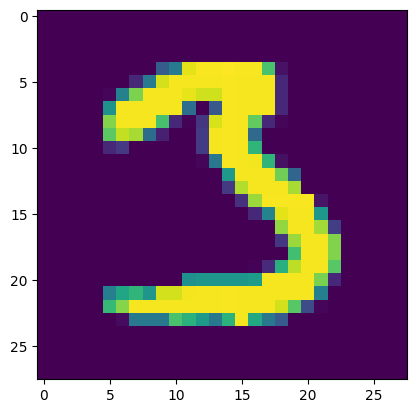

In [ ]:
imagem, rotulo = MNIST_treino[11111]

imshow(imagem[0])
print(rotulo)

In [ ]:
class MLP(nn.Module):
  #Definição da nossa própria multi-layered perceptron
  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    #Definição das camadas e das funções de ativação intermediárias
    # aqui escolhemos duas redes lineares e como funções de ativação, ReLU duas vezes
    self.features  = nn.Sequential(
                        nn.Linear(input_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU())
    #A de saída também será linear
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()
    #Como estamos lidando com um processo de classificação, passaremos por um softmax

  def forward(self, X):
    #Define a computação de cada chamada
    X = X.view(X.size(0), -1)

    feature = self.features(X)
    output  = self.softmax(self.out(feature))

    return output

  #Definição da quantidade de neurônios
  input_size  = 28 * 28
  hidden_size = 128
  out_size    = 10 #classes
